In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("../libs/")
from utils import shift_join_data, mae,rmse,mape
from models import build_mlp

Using TensorFlow backend.


# Carga de datos

In [2]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

In [3]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2145 entries, ('DEU', 1991) to ('NZL', 2021)
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2145 non-null   float64
 1   exports      2145 non-null   float64
 2   imports      2145 non-null   float64
 3   ggfce        2145 non-null   float64
 4   gfcf         2145 non-null   float64
 5   industry     2145 non-null   float64
 6   manufact     2145 non-null   float64
 7   unempl       2145 non-null   float64
 8   agriculture  2145 non-null   float64
 9   rgdp_growth  2145 non-null   float64
 10  infl_cpi     2145 non-null   float64
 11  oil          2145 non-null   float64
 12  gold         2145 non-null   float64
 13  copper       2145 non-null   float64
 14  sp500        2145 non-null   float64
dtypes: float64(15)
memory usage: 260.6+ KB


# Dividir Datos

In [5]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]

In [6]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


In [7]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'industry', 'manufact',
       'unempl', 'agriculture', 'infl_cpi', 'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


# Normalizar

In [8]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df.loc[iso_test][features].copy()
df_y_test = df.loc[iso_test][target_col].copy()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_y_train.iloc[:,:] = np.clip(df_y_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)
df_y_test.iloc[:,:] = np.clip(df_y_test,-5,5)

# Generar variables lag y horizonte

In [9]:
n_steps_in = 4
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)

In [10]:
help(build_mlp)

Help on function build_mlp in module models:

build_mlp(n_steps_in: int, n_features: int, n_steps_out: int, nodes: int, layers: int, learning_rate: float, activation=None, metrics=None)
    Construye un Perceptron Multicapa (MLP)
    
    Parametros
    ----------
    n_steps_in : int
        Pasos de tiempo a pasado de entrada
    n_features : int
        Numero de caracteristicas de la entrada
    n_steps_out : int
        Pasos de tiempo a futuro de salida
    nodes : int
        Numero de nodos por capa oculta
    layers : int
        Numero de capas ocultas
    learning_rate : float
        Ratio de aprendizaje
    activation : 
        Funcion de activacion.
    metrics : Any
        Lista de Metricas
    
    Resultado
    ---------
    model : Sequential
        Modelo MLP construido



In [11]:
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=False)

In [13]:
n_batch = len(x_train)

In [14]:
n_batch

1744

In [15]:
mlp = build_mlp(n_steps_in,n_features,n_steps_out,250,2,1e-4,'tanh')

In [16]:
history = mlp.fit(x_train,y_train,epochs=2000,batch_size=n_batch,validation_split=0.2,verbose=0,callbacks=[es],shuffle=False)

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_loss(history,metric):
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(history.history[metric],label='train '+metric)
    ax.plot(history.history['val_'+metric],label='validation '+metric)
    ax.legend()

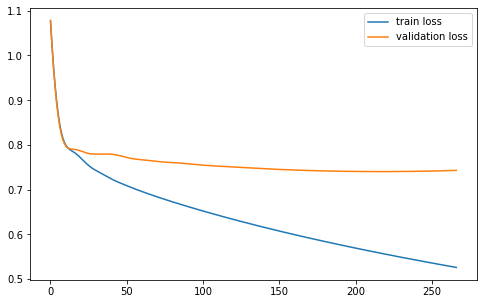

In [19]:
plot_loss(history,'loss')

In [20]:
y_pred = mlp.predict(x_test)

In [21]:
dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

In [22]:
mae(dn_y_test, dn_y_pred)

array([3.24386116, 3.77775708, 3.90398688])

In [23]:
rmse(dn_y_test, dn_y_pred)


array([4.49894328, 4.84935365, 5.56566628])

In [24]:
print(mape(y_test,y_pred))
print(mape(dn_y_test,dn_y_pred))

[ 699.57985937 1177.0325487   179.13578246]
[154.1968161  191.32841144 213.5539683 ]


In [25]:
def plot_pred(orig,pred):
    y_o, y_p = orig.T, pred.T
    n = len(y_o)
    fig, axes = plt.subplots(n,figsize=(5,12))
    for i in range(n):
        line_o, = axes[i].plot(y_o[i],label='orig')
        line_p, = axes[i].plot(y_p[i],label='pred')
        axes[i].legend(handles=[line_o,line_p])

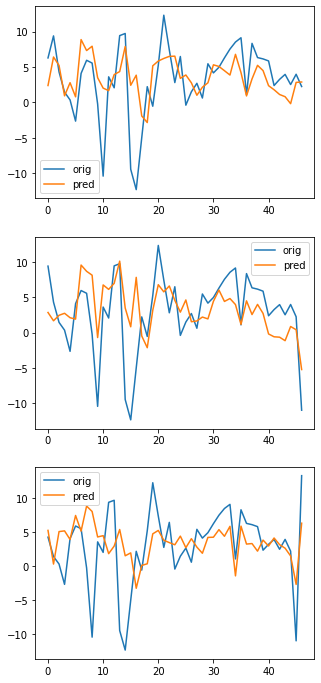

In [26]:
plot_pred(dn_y_test, dn_y_pred)

In [27]:
help(build_cnn)

Help on function build_cnn in module models:

build_cnn(n_steps_in: int, n_features: int, n_steps_out: int, kernels: int, kernel_size: int, nodes: int, learning_rate: float, activation=None, metrics=None)
    Construye una Red Convolucional (CNN)
    
    Parametros
    ----------
    n_steps_in : int
        Pasos de tiempo a pasado de entrada
    n_features : int
        Numero de caracteristicas de la entrada
    n_steps_out : int
        Pasos de tiempo a futuro de salida
    kernels : int
        Numero de kernels
    kernel_size : int
        Tamano de kernel
    nodes : int
        Numero de nodos por capa oculta
    learning_rate : float
        Ratio de aprendizaje
    activation : 
        Funcion de activacion.
    metrics : Any
        Lista de Metricas
    
    Resultado
    ---------
    model : Sequential
        Modelo CNN construido



In [28]:
cnn = build_cnn(n_steps_in, n_features, n_steps_out, 250, 3,100,1e-5,'tanh')

In [29]:
history2 = cnn.fit(x_train,y_train,epochs=1000,batch_size=n_batch,validation_split=0.2,verbose=0,callbacks=[es],shuffle=False)

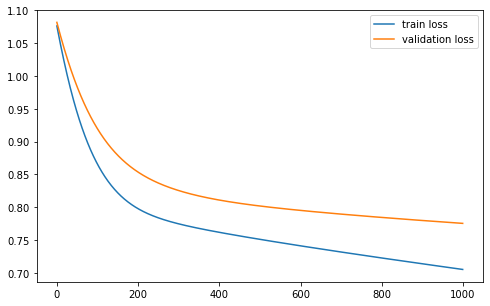

In [30]:
plot_loss(history2,'loss')

[3.61979617 4.03176253 4.01915885]
[5.08918944 5.55960472 5.66936451]
[144.03373796 160.56855643 134.97974293]


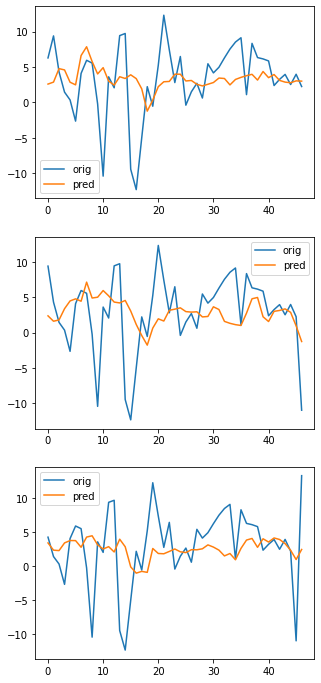

In [31]:
y_pred = cnn.predict(x_test)

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

print(mae(dn_y_test,dn_y_pred))
print(rmse(dn_y_test,dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

plot_pred(dn_y_test,dn_y_pred)

In [32]:
help(build_lstm)

Help on function build_lstm in module models:

build_lstm(n_steps_in: int, n_features: int, n_steps_out: int, cells: int, layers_lstm: int, layers_dense: int, learning_rate: float, activation=None, metrics=None)
    Construye una Red LSTM
    
    Parametros
    ----------
    n_steps_in : int
        Pasos de tiempo a pasado de entrada
    n_features : int
        Numero de caracteristicas de la entrada
    n_steps_out : int
        Pasos de tiempo a futuro de salida
    cells : int
        Numero de celulas por capa recurrente
    layers_lstm : int
        Numero de capas recurrentes
    layers_dense : int
        Numero de capas densas
    learning_rate : float
        Ratio de aprendizaje
    activation : 
        Funcion de activacion.
    metrics : Any
        Lista de Metricas
    
    Resultado
    ---------
    model : Sequential
        Modelo LSTM construido



In [33]:
lstm = build_lstm(n_steps_in, n_features, n_steps_out, 250,3,1e-4,'tanh')

In [34]:
history3 = lstm.fit(x_train,y_train,epochs=1000,batch_size=n_batch,validation_split=0.2,verbose=0,callbacks=[es],shuffle=False)

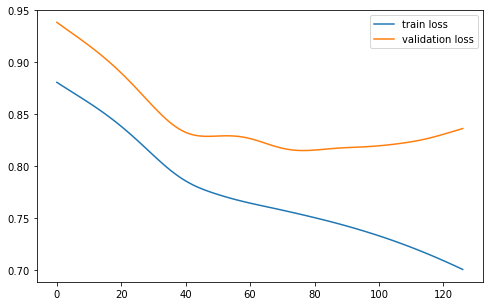

In [35]:
plot_loss(history3,'loss')

[3.62649468 4.11336061 4.19741701]
[5.14420372 5.6763995  5.93081335]
[150.21627788 170.93043693 158.27971148]


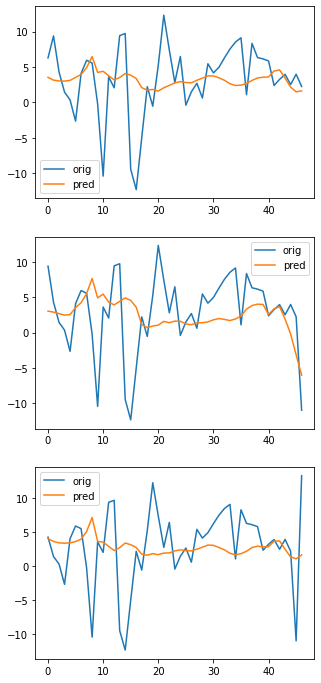

In [36]:
y_pred = lstm.predict(x_test)

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

print(mae(dn_y_test,dn_y_pred))
print(rmse(dn_y_test,dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

plot_pred(dn_y_test,dn_y_pred)

In [37]:
#help(build_gru)

In [38]:
gru = build_gru(n_steps_in, n_features, n_steps_out, 250,2,1e-4,'tanh')

In [39]:
history4 = gru.fit(x_train,y_train,epochs=1000,batch_size=n_batch,validation_split=0.2,verbose=0,callbacks=[es],shuffle=False)

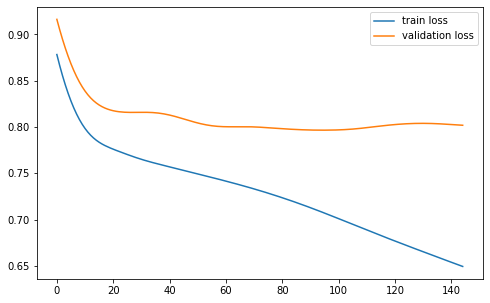

In [40]:
plot_loss(history4,'loss')

[3.69968942 3.92848179 4.06073322]
[5.28957597 5.54913797 5.73488797]
[153.27156049 144.50068001 149.16269497]


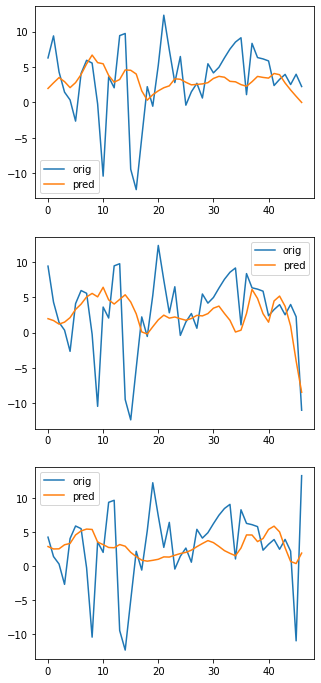

In [41]:
y_pred = gru.predict(x_test)

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

print(mae(dn_y_test,dn_y_pred))
print(rmse(dn_y_test,dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

plot_pred(dn_y_test,dn_y_pred)

In [42]:
#help(build_seq2seq)

In [43]:
seq2seq = build_seq2seq(n_steps_in, n_features, n_steps_out, 500,1e-4,'tanh')

In [44]:
history5 = seq2seq.fit(x_train,y_train,epochs=1000,batch_size=n_batch,validation_split=0.2,verbose=0,callbacks=[es],shuffle=False)

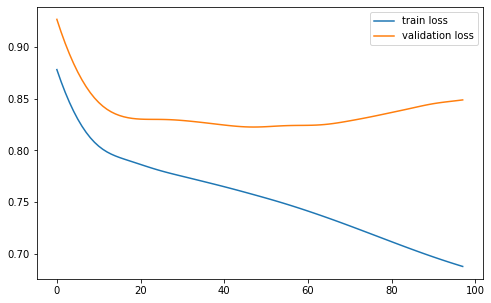

In [45]:
plot_loss(history5,'loss')

[3.74195737 3.95203078 4.28609542]
[5.14134174 5.48926566 6.15584503]
[154.5810483  164.60328324 147.00260086]


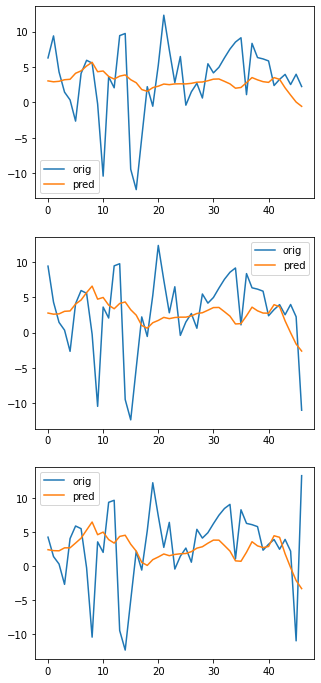

In [46]:
y_pred = seq2seq.predict(x_test)
y_shape = y_pred.shape
y_pred = y_pred.reshape((y_shape[0], y_shape[1]))

dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)

print(mae(dn_y_test,dn_y_pred))
print(rmse(dn_y_test,dn_y_pred))
print(mape(dn_y_test,dn_y_pred))

plot_pred(dn_y_test,dn_y_pred)